In [ ]:
%%capture
! pip install numpy opencv-python pyproj Pillow pandas matplotlib requests
! pip install 'urllib3<2'
! pip install pyproj

## Multi-Model Model

In [ ]:
import os
import io
import numpy as np
import logging
import time
import cv2

import math
import pyproj
import numpy as np
from PIL import Image
import pandas as pd

from matplotlib import pyplot as plt

import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [ ]:
# Semi-axes of WGS-84 geoidal reference
WGS84_a = 6378137.0  # Major semiaxis [m]
WGS84_b = 6356752.3  # Minor semiaxis [m]

geod = pyproj.Geod(ellps='WGS84')

# degrees to radians
def deg2rad(degrees):
    return math.pi * degrees / 180.0


# radians to degrees
def rad2deg(radians):
    return 180.0 * radians / math.pi


# Earth radius at a given latitude, according to the WGS-84 ellipsoid [m]
def WGS84EarthRadius(lat):
    # http://en.wikipedia.org/wiki/Earth_radius
    An = WGS84_a * WGS84_a * math.cos(lat)
    Bn = WGS84_b * WGS84_b * math.sin(lat)
    Ad = WGS84_a * math.cos(lat)
    Bd = WGS84_b * math.sin(lat)
    return math.sqrt((An * An + Bn * Bn) / (Ad * Ad + Bd * Bd))


# Bounding box surrounding the point at given coordinates,
# assuming local approximation of Earth surface as a sphere
# of radius given by WGS84
def boundingBox(latitudeInDegrees, longitudeInDegrees, halfSideBboxInm):
    lat = deg2rad(latitudeInDegrees)
    lon = deg2rad(longitudeInDegrees)

    # Radius of Earth at given latitude
    radius = WGS84EarthRadius(lat)
    # Radius of the parallel at given latitude
    pradius = radius * math.cos(lat)

    latMin = lat - halfSideBboxInm / radius
    latMax = lat + halfSideBboxInm / radius
    lonMin = lon - halfSideBboxInm / pradius
    lonMax = lon + halfSideBboxInm / pradius

    return [rad2deg(lonMin), rad2deg(latMin), rad2deg(lonMax), rad2deg(latMax)]

def calculate_distance(long1,lat1,long2,lat2):
    if lat1==lat2 and long1==long2:
        return 0
    if False in np.isfinite([long1, long2, lat1, lat2]):
        return np.nan
    if lat1 < -90 or lat1 > 90 or lat2 < -90 or lat2 > 90:
        #raise ValueError('The range of latitudes seems to be invalid.')
        return np.nan
    if long1 < -180 or long1 > 180 or long2 < -180 or long2 > 180:
        return np.nan
    angle1,angl2,distance = geod.inv(long1,lat1,long2,lat2)
    return distance


class ExtractStreetImages:
    def __init__(self, latitude, longitude, client_token, radius=200, pxl_width=1024, cordinate_ref_system="EPSG:4326"):
        self.metadata_endpoint = "https://graph.mapillary.com"
        self.headers = {"Authorization": "OAuth {}".format(client_token)}
        self.pixel_width = pxl_width  # can take 256/1024/2048
        self.latitude = latitude
        self.longitude = longitude
        self.crs = cordinate_ref_system
        self.radius = radius

    def get_street_dataframe(self, ):
        street_dataframe = None
        bbox = boundingBox(self.latitude, self.longitude, self.radius)
        url_imagesearch = self.metadata_endpoint + '/images?fields=id,' \
                                                   'thumb_{}_url,' \
                                                   'captured_at,' \
                                                   'compass_angle,' \
                                                   'geometry&bbox= ' \
                                                   '{},{},{},{}'.format(self.pixel_width, bbox[0],
                                                                        bbox[1], bbox[2], bbox[3])
        try:
            data_imagesearch = requests.get(url_imagesearch, headers=self.headers, timeout=None).json()
            street_dataframe = self.convert2dataframe(data_imagesearch)
        except ConnectionError as err:
            logging.error("ERROR:{}".format(err))
        return street_dataframe

    def convert2dataframe(self, data_imagesearch):
        street_df = None
        if len(data_imagesearch['data']) > 0:
            street_df = pd.json_normalize(data_imagesearch, record_path=['data'])
            street_df['DateTime'] = pd.to_datetime(street_df['captured_at'].apply(
                lambda x: time.strftime("%D %H:%M", time.localtime(x / 1000))))
            # capture date and hour from data frame
            street_df['Date'] = street_df['DateTime'].dt.normalize()
            street_df['Hour'] = street_df['DateTime'].dt.hour
            street_df = street_df.drop(['captured_at'], axis=1, inplace=False)
        else:
            logging.warning('No Image Data found at co-ordinates')
        return street_df

    def convert2geodataframe(self, dataframe):
        gpd_dataframe = None
        try:
            import geopandas as gpd
            dataframe['geometry'] = gpd.points_from_xy(
                pd.DataFrame(dataframe['geometry.coordinates'].to_list())[0],
                pd.DataFrame(dataframe['geometry.coordinates'].to_list())[1])
            gpd_dataframe = gpd.GeoDataFrame(dataframe, geometry=dataframe['geometry'], crs=self.crs)
        except ImportError as err:
            logging.error(err)
        return gpd_dataframe

    def generate_video_data(self,image_urls,shape=(640,640),out_path='video.avi'):
        fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        video = cv2.VideoWriter('video.avi', 0, 15, (shape[0], shape[1]))
        for img_url in image_urls:
            image = self.fetch_img(img_url)
            video.write(image)
        cv2.destroyAllWindows()
        video.release()
        return 0



    @staticmethod
    def get_street_hour_dataframe(data_frame, start_period, end_period=None):
        street_df = data_frame
        if end_period is None:
            street_df = street_df.loc[data_frame['Hour'] > start_period]
        else:
            street_df = street_df.loc[(street_df['Hour'] > start_period) & (street_df['Hour'] < end_period)]
        return street_df

    @staticmethod
    def fetch_img(url):
        image = None
        retry_strategy = Retry(total=3, status_forcelist=[429, 502, 503, 504],
                               method_whitelist=["HEAD", "GET", "OPTIONS"], )
        adapter = HTTPAdapter(max_retries=retry_strategy)
        http = requests.Session()
        http.mount("https://", adapter)
        response = http.get(url)
        if not response.status_code == 200:
            logging.error('Error code :{}'.format(response.status_code))
        try:
            image = np.asarray(Image.open(io.BytesIO(response.content)))
        except IOError as err:
            logging.error("Error {}".format(err))
        return image

    @staticmethod
    def get_poi_distances(dataframe, poi_latitude, poi_longitude, index_name='geometry.coordinates'):
        dataframe['poi_distance'] = dataframe.apply(lambda z: calculate_distance(
            float(z[index_name][0]), float(z[index_name][1]), poi_longitude, poi_latitude), axis=1)
        return dataframe


In [ ]:
client_token = 'your Mappilary token'
latitude =   40.71598
longitude =  -74.002881
mappilary_endpoint = ExtractStreetImages(latitude,longitude,client_token,pxl_width=1024,radius=100)

In [ ]:
street_images_df = mappilary_endpoint.get_street_dataframe()
print(street_images_df.shape)
street_images_df = street_images_df.sort_values(by='DateTime',ascending=False)
street_images_df.head()

(320, 8)


id                                     thumb_1024_url  \
244   732320555407697  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
190   327051643509115  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
24   1386916791905772  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
115  1800134177113591  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
178  2142546189287459  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   

     compass_angle geometry.type                 geometry.coordinates  \
244     163.133613         Point  [-74.003487518949, 40.715637447374]   
190     259.326308         Point  [-74.003484426017, 40.715534367712]   
24      252.561070         Point  [-74.003514891387, 40.715520435384]   
115     213.552861         Point  [-74.003541798622, 40.715501787289]   
178     123.411562         Point  [-74.003476861313, 40.715584030656]   

               DateTime       Date  Hour  
244 2023-11-13 12:50:00 2023-11-13    12  
190 2023-11-13 12:50:00 2023-11-13    12  
24  2023-11-13 12:50:00 2023-11-13    12  
115 2023-11-13 12:50:00 2023-11-13    12  
178 2023-11-13 12:50:00 2023-11-13    12

<ipython-input-4-76ee198f82da>:137: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(total=3, status_forcelist=[429, 502, 503, 504],


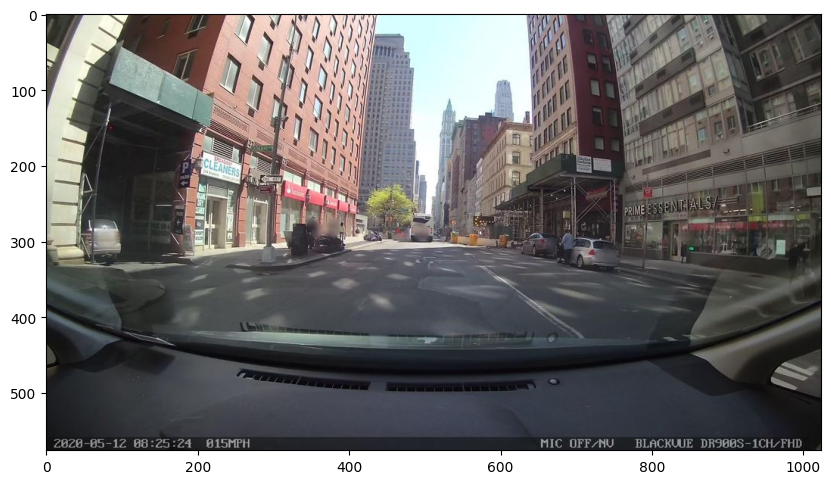

In [ ]:
plt.figure(figsize=(10,7))
img_list = street_images_df['thumb_1024_url'].values.tolist()

random_num = np.random.randint(0,street_images_df.shape[0])
plt.imshow(mappilary_endpoint.fetch_img(img_list[random_num]))

## Filter data on Hourly basis
In case we need to ignore night images to avoid low visibility data.

In [ ]:
street_hour_df = mappilary_endpoint.get_street_hour_dataframe(street_images_df,start_period=9,end_period=20)
street_hour_df.head(4)

id                                     thumb_1024_url  \
244   732320555407697  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
190   327051643509115  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
24   1386916791905772  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
115  1800134177113591  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   

     compass_angle geometry.type                 geometry.coordinates  \
244     163.133613         Point  [-74.003487518949, 40.715637447374]   
190     259.326308         Point  [-74.003484426017, 40.715534367712]   
24      252.561070         Point  [-74.003514891387, 40.715520435384]   
115     213.552861         Point  [-74.003541798622, 40.715501787289]   

               DateTime       Date  Hour  
244 2023-11-13 12:50:00 2023-11-13    12  
190 2023-11-13 12:50:00 2023-11-13    12  
24  2023-11-13 12:50:00 2023-11-13    12  
115 2023-11-13 12:50:00 2023-11-13    12

In [ ]:
street_hour_df.size

2560

## Filter data on basis of Distance
in case We need to select images within a range of 50 to 100 meters only

In [ ]:
street_images_df = mappilary_endpoint.get_poi_distances(street_images_df,latitude,longitude,index_name='geometry.coordinates')
street_images_df.head(4)

id                                     thumb_1024_url  \
244   732320555407697  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
190   327051643509115  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
24   1386916791905772  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
115  1800134177113591  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   

     compass_angle geometry.type                 geometry.coordinates  \
244     163.133613         Point  [-74.003487518949, 40.715637447374]   
190     259.326308         Point  [-74.003484426017, 40.715534367712]   
24      252.561070         Point  [-74.003514891387, 40.715520435384]   
115     213.552861         Point  [-74.003541798622, 40.715501787289]   

               DateTime       Date  Hour  poi_distance  
244 2023-11-13 12:50:00 2023-11-13    12     63.823253  
190 2023-11-13 12:50:00 2023-11-13    12     71.053480  
24  2023-11-13 12:50:00 2023-11-13    12     73.981386  
115 2023-11-13 12:50:00 2023-11-13    12     77.055932

In [ ]:
street_mindist_df = street_images_df.loc[street_images_df['poi_distance']<30]
print("Found {} images for given distance and period".format(street_mindist_df.shape[0]))

Found 7 images for given distance and period


In [ ]:
street_mindist_df = street_mindist_df.sort_values(by='poi_distance')
street_mindist_df

id                                     thumb_1024_url  \
204  1153500351740968  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
131  2915877325398587  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
14    302156641364234  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
169   206290897727851  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
175   297270081954512  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
224   468753947783891  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   
180   466832301279095  https://scontent-iad3-1.xx.fbcdn.net/m1/v/t6/A...   

     compass_angle geometry.type         geometry.coordinates  \
204      84.650436         Point  [-74.00293137, 40.71598128]   
131      84.766968         Point  [-74.00287025, 40.71604552]   
14       86.613022         Point  [-74.00278114, 40.71607812]   
169     299.002991         Point  [-74.00302925, 40.71586596]   
175      63.530647         Point  [-74.00303001, 40.71586404]   
224      90.150482         Point  [-74.00272809, 40.71613127]   
180      68.667862         Point   [-74.0030869, 40.71581049]   

               DateTime       Date  Hour  poi_distance  
204 2014-08-13 11:23:00 2014-08-13    11      4.258402  
131 2014-08-13 11:23:00 2014-08-13    11      7.332371  
14  2014-08-13 11:23:00 2014-08-13    11     13.781113  
169 2014-08-13 11:24:00 2014-08-13    11     17.812570  
175 2014-08-13 11:24:00 2014-08-13    11     18.009616  
224 2014-08-13 11:23:00 2014-08-13    11     21.192294  
180 2014-08-13 11:24:00 2014-08-13    11     25.632261

<ipython-input-4-76ee198f82da>:137: DeprecationWarning: Using 'method_whitelist' with Retry is deprecated and will be removed in v2.0. Use 'allowed_methods' instead
  retry_strategy = Retry(total=3, status_forcelist=[429, 502, 503, 504],


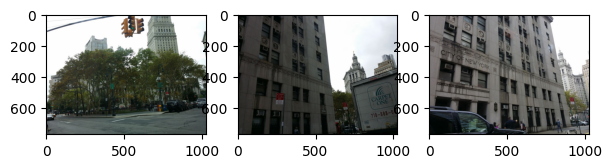

In [ ]:
img_list = street_mindist_df['thumb_1024_url'].values.tolist()
n_images = np.random.choice(img_list,3)
plt.figure(figsize=(7,15))
plt.subplot(1,3,1)
plt.imshow(mappilary_endpoint.fetch_img(n_images[0]))

plt.subplot(1,3,2)
plt.imshow(mappilary_endpoint.fetch_img(n_images[1]))

plt.subplot(1,3,3)
plt.imshow(mappilary_endpoint.fetch_img(n_images[2]))


# Use segment anything SAM - sam has prompts in the form of Point, box NOT text

In [ ]:
%%capture
! pip install git+https://github.com/facebookresearch/segment-anything.git
! pip install -q transformers torch

Use CLIPSeg to do text based prompts

In [ ]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

(768, 1024, 3)


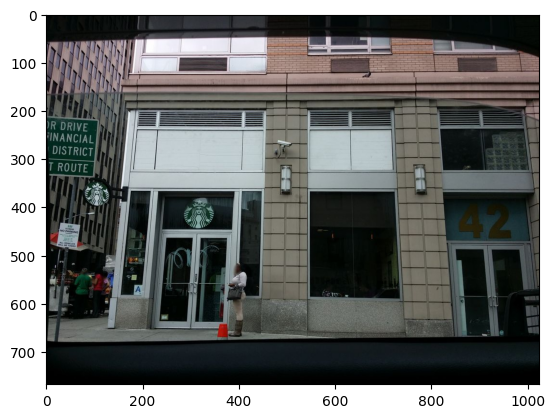

In [ ]:
import urllib
prompts = ["door", "gate","entry"]

url = img_list[3]
url_response = urllib.request.urlopen(url)
img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
image = cv2.imdecode(img_array, -1)

image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
print(image.shape)
plt.imshow(image)

### Run Clip Model on Image

In [ ]:
import torch

inputs = processor(
    text=prompts,
    images=[image] * len(prompts),
    padding="max_length",
    return_tensors="pt",
)
with torch.no_grad():  # Use 'torch.no_grad()' to disable gradient computation
    outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)
door_detection = outputs.logits[0]  # Assuming class index 0

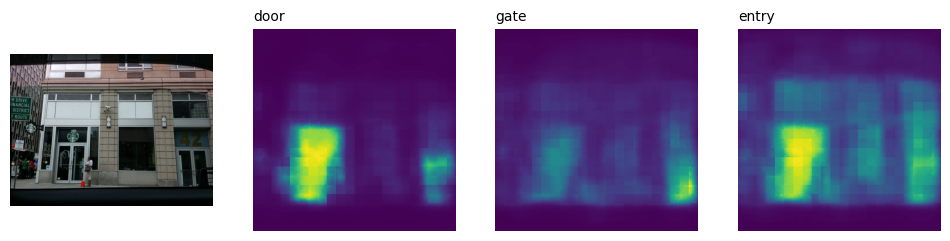

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];


(352, 352) <class 'numpy.ndarray'>


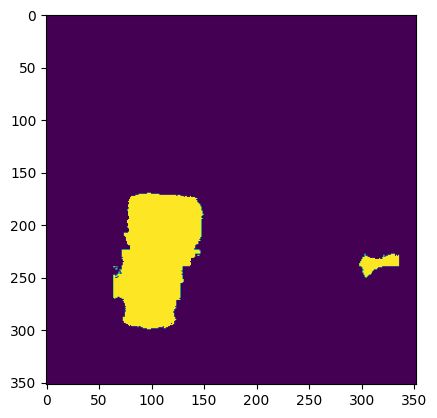

In [ ]:
predicted_image =  torch.sigmoid(preds[0][0]).detach().cpu().numpy()
predicted_image = np.where(predicted_image>0.50,255,0)
print(predicted_image.shape,type(predicted_image))
plt.imshow(predicted_image)

In [ ]:
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
# from skimage.util.montage import montage2d as montage

lbl_0 = label(predicted_image)
props = regionprops(lbl_0)

Found bbox (170, 64, 300, 150)
Found bbox (228, 298, 251, 336)
Found bbox (229, 144, 230, 146)
Found bbox (240, 64, 241, 66)
Found bbox (240, 67, 241, 68)
Found bbox (242, 66, 243, 68)


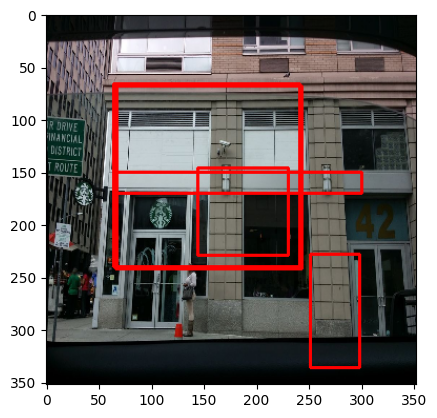

In [ ]:
resize_image = cv2.resize(image,(352,352))
resize_image_copy= resize_image.copy()
for prop in props:
        print('Found bbox', prop.bbox)
        # cv2.rectangle(resize_image, (34,153), ( 284,321), (255, 0, 0), 2)
        cv2.rectangle(resize_image_copy, (prop.bbox[1], prop.bbox[0]), (prop.bbox[2], prop.bbox[3]), (255, 0, 0), 2)
plt.imshow(resize_image_copy)

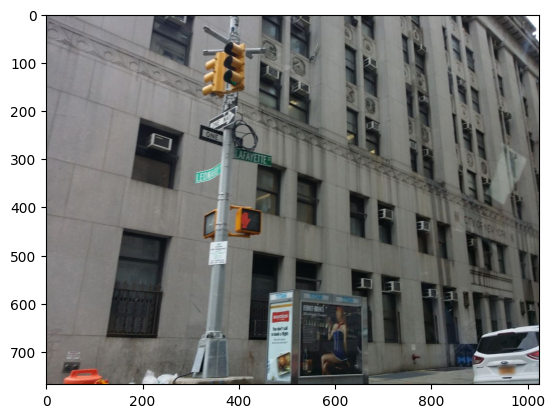

In [ ]:
## Run inference in a function
import torch

def read_image_url(image_url):
    url_response = urllib.request.urlopen(image_url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    image = cv2.imdecode(img_array, -1)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def rescale_bbox(bbox,orig_image_shape=(1024,1024),model_shape=352):
    bbox = np.asarray(bbox)/model_shape
    y1,y2 = bbox[::2] *orig_image_shape[0]
    x1,x2 = bbox[1::2]*orig_image_shape[1]
    return [int(y1),int(x1),int(y2),int(x2)]

def detect_using_clip(image,prompts=[],threshould=0.4):
    model_detections = dict()
    inputs = processor(
        text=prompts,
        images=[image] * len(prompts),
        padding="max_length",
        return_tensors="pt",
    )
    with torch.no_grad():  # Use 'torch.no_grad()' to disable gradient computation
        outputs = model(**inputs)
    preds = outputs.logits.unsqueeze(1)
    detection = outputs.logits[0]  # Assuming class index 0
    for i,prompt in enumerate(prompts):
        predicted_image =  torch.sigmoid(preds[i][0]).detach().cpu().numpy()
        predicted_image = np.where(predicted_image>threshould,255,0)
        # extract countours from the image
        lbl_0 = label(predicted_image)
        props = regionprops(lbl_0)
        model_detections[prompt] = [rescale_bbox(prop.bbox,orig_image_shape=image.shape[:2],model_shape=predicted_image.shape[0]) for prop in props]

    return model_detections

rgb_image = read_image_url(img_list[5])
plt.imshow(rgb_image)


In [ ]:
def display_images(image,detections,prompt='traffic light'):
    H,W = image.shape[:2]
    image_copy = image.copy()
    if prompt not in detections.keys():
        print("prompt not in query ..")
        return image_copy
    for bbox in detections[prompt]:
        cv2.rectangle(image_copy, (int(bbox[1]), int(bbox[0])), (int(bbox[3]), int(bbox[2])), (255, 0, 0), 2)
    return image_copy

prompts = ["door", "gate","entry",'window','banner','traffic light','Cars']
predictions = detect_using_clip(image=rgb_image,prompts=prompts)

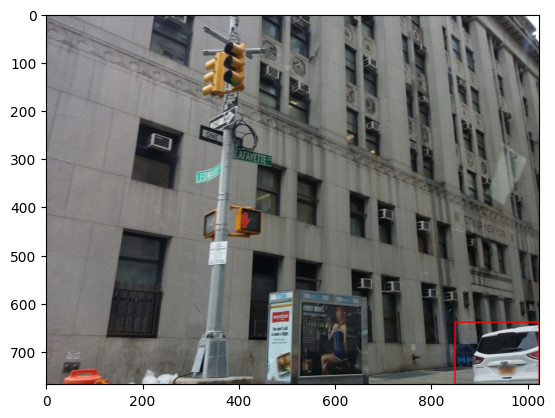

In [ ]:
plt.imshow(display_images(rgb_image,detections=predictions,prompt='Cars'))